In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from Levenshtein import distance
from abnumber import Chain

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=64)

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
# Set plotting parameters for Seaborn
sns.set(rc = {'figure.figsize':(4,4),  'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = 1, palette='colorblind')
sns.set_style('ticks')

In [5]:
def lev_identity(seq1, seq2):
    '''Get identity between two strings using Levenshtein distance, normalized by length of longer sequence.'''
    lev_dist = distance(seq1, seq2)
    max_len = max(len(seq1), len(seq2))
    norm_dist = lev_dist / max_len
    norm_identity = 1 - norm_dist

    return norm_identity

In [6]:
# Concatenated output file containing sequences selected for experimental validation, with AUC values added in from Prism calculation
seq_df = pd.read_csv('selected_gen_Abs.csv', index_col=0)

In [7]:
training_seqs = pd.read_csv('fully_annotated_V2_training_seqs_24-04-11.csv', index_col=0)

In [8]:
def add_matching_gene_label(row, comparison_df):
    if (row['v_gene.H'] == comparison_df['v_gene.H']) and (row['v_gene.L'] == comparison_df['v_gene.L']):
        return 'Same V genes'
    if (row['v_gene.H'] == comparison_df['v_gene.H']) and (row['v_gene.L'] != comparison_df['v_gene.L']):
        return 'Same VH gene'
    if (row['v_gene.H'] != comparison_df['v_gene.H']) and (row['v_gene.L'] == comparison_df['v_gene.L']):
        return 'Same VL gene'
    if (row['v_gene.H'] != comparison_df['v_gene.H']) and (row['v_gene.L'] != comparison_df['v_gene.L']):
        return 'Different V genes'

In [9]:
training_seqs['v_gene.H'] = training_seqs['v_gene.H_x'].apply(lambda x: x.split('*')[0])
training_seqs['v_gene.L'] = training_seqs['v_gene.L'].apply(lambda x: x.split('*')[0])

In [10]:
seq_df['v_gene.H'] = seq_df['v_gene.H'].replace({'IGHV3-53':'IGHV3-53/66', 'IGHV3-66':'IGHV3-53/66'})
training_seqs['v_gene.H'] = training_seqs['v_gene.H'].replace({'IGHV3-53':'IGHV3-53/66', 'IGHV3-66':'IGHV3-53/66'})

In [11]:
def lev_identity_short(seq1, seq2):
    lev_dist = distance(seq1, seq2)
    min_len = min(len(seq1), len(seq2))
    norm_dist = lev_dist / min_len
    norm_identity = 1 - norm_dist

    return norm_identity

# WT RBD sequence from uniprot
rbd = 'RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF'

training_seqs['rbd_identity'] = training_seqs['antigen_seq'].apply(lambda x: lev_identity_short(x, rbd))
training_seqs.shape

(18507, 58)

In [12]:
# Getting antibodies that bind RBD or spike
training_seqs[training_seqs['antigen_seq'].apply(lambda x: rbd in x)]['antigen_name'].value_counts().head()

antigen_name
SARS-CoV2_WT S; RBD    2674
CoV_SARS2               322
RBD                     303
wt_Spike                270
spike glycoprotein      154
Name: count, dtype: int64

In [13]:
def get_min_distance(row):
    vh = row['VH']
    vl = row['VL']
    training_seqs['VH_dist'] = training_seqs['VH_abnum'].apply(lambda x: distance(x, vh))
    training_seqs['VL_dist'] = training_seqs['VL_abnum'].apply(lambda x: distance(x, vl))

    min_dist_idx = (training_seqs['VH_dist'] + training_seqs['VL_dist']).idxmin()
    min_dist = (training_seqs['VH_dist'] + training_seqs['VL_dist']).min()

    # Now, for match, get VH and VL distance:

    min_vh_dist = distance(training_seqs.drop_duplicates(subset='VH_abnum').loc[min_dist_idx]['VH_abnum'], vh)
    min_vl_dist = distance(training_seqs.drop_duplicates(subset='VH_abnum').loc[min_dist_idx]['VL_abnum'], vl)
    
    return pd.Series([min_dist_idx, min_dist, min_vh_dist, min_vl_dist])

In [14]:
seq_df[['min_dist_training_match', 'min_dist_training', 'min_vh_dist', 'min_vl_dist']] = seq_df.parallel_apply(get_min_distance, axis=1)

In [15]:
biased_group = seq_df.loc[['RBD-153','RBD-159','RBD-373','RBD-850','RBD-951','RBD-187','RBD-238','RBD-409','RBD-413','RBD-446']]
# biased_group.to_csv('biased_antibody_group_V2_24-06-05.csv')

In [16]:
def get_CDRH3_match(row):
    cdr3 = row['CDR3.H']
    training_seqs['CDRH3_dist'] = training_seqs['CDR3.H'].apply(lambda x: lev_identity(x, cdr3))

    min_dist_idx = training_seqs['CDRH3_dist'].idxmax()
    min_dist = training_seqs['CDRH3_dist'].max()
    
    return pd.Series([min_dist_idx, min_dist])

def get_VH_match(row):
    vh = row['VH']
    training_seqs['VH_dist'] = training_seqs['VH_abnum'].apply(lambda x: lev_identity(x, vh))

    min_dist_idx = training_seqs['VH_dist'].idxmax()
    min_dist = training_seqs['VH_dist'].max()
    
    return pd.Series([min_dist_idx, min_dist])

In [17]:
seq_df[['min_CDRH3_identity', 'CDRH3_match']] = seq_df.parallel_apply(get_CDRH3_match, axis=1)
seq_df[['min_VH_identity', 'VH_match']] = seq_df.parallel_apply(get_VH_match, axis=1)

In [18]:
# training_seqs.loc[biased_group['min_dist_training_match']].to_csv('biased_antibody_group_matches_V2_24-06-05.csv')

/tmp/ipykernel_1699344/3786300672.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


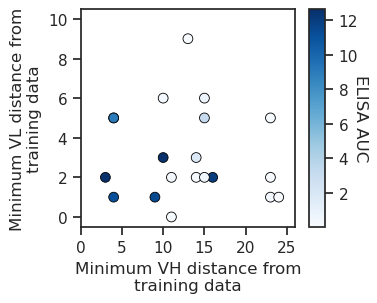

In [19]:
sns.set(rc = {'figure.figsize':(4,3.2),  'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = 1, palette='colorblind')
sns.set_style('ticks')

fig, ax = plt.subplots()

sns.scatterplot(x=seq_df['min_vh_dist'], y = seq_df['min_vl_dist'], hue = seq_df['ELISA AUC'], palette='Blues',
                edgecolor="black", linewidth=0.6, s=50, legend=False)

plt.xlabel('Minimum VH distance from\ntraining data')
plt.ylabel('Minimum VL distance from\ntraining data')

norm = plt.Normalize(seq_df['ELISA AUC'].min(), seq_df['ELISA AUC'].max())

sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
plt.xticks([-0,5,10,15,20,25])
plt.ylim(-0.5,10.5)
plt.xlim(0,26)

# Remove the legend and add a colorbar
ax.set_aspect(2.4, adjustable='box')

cbar_ax = fig.add_axes([0.85, 0.264, 0.04, 0.679])  # Position and size of the colorbar
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('ELISA AUC', labelpad=7,rotation=270)

plt.tight_layout()

# plt.savefig('min_dist_ELISA_scatter_v1_24-06-05.svg')

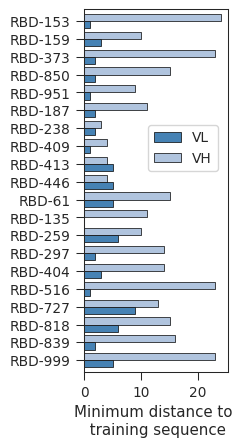

In [20]:
sns.set(rc = {'figure.figsize':(2.5,4.6),  'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white', "axes.linewidth":0.75, "ytick.major.width":0.75, "xtick.major.width":0.75}, font_scale = 0.9, palette='colorblind')
sns.set_style('ticks')

order = ['RBD-153','RBD-159','RBD-373','RBD-850','RBD-951','RBD-187','RBD-238','RBD-409','RBD-413','RBD-446','RBD-61','RBD-135',
         'RBD-259','RBD-297','RBD-404','RBD-516','RBD-727','RBD-818','RBD-839','RBD-999']
order.reverse()

plot_df = seq_df[['min_vl_dist','min_vh_dist']].loc[order]
plot_df.columns = ['VL', 'VH']

plot_df.plot.barh(width=0.8, color=['steelblue', 'lightsteelblue'],edgecolor='black', linewidth=0.5)
plt.xlabel('Minimum distance to \n training sequence')

plt.legend(bbox_to_anchor=(0.4,0.7))

plt.tight_layout()

# plt.savefig('min_dist_ordered_abs.svg')

### Looking at RBD-binders confirmed by ELISA

In [21]:
rbd_hit_df = seq_df.loc[['RBD-839', 'RBD-61', 'RBD-404', 'RBD-446', 'RBD-413', 'RBD-409',  'RBD-238', 'RBD-951', 'RBD-159']]

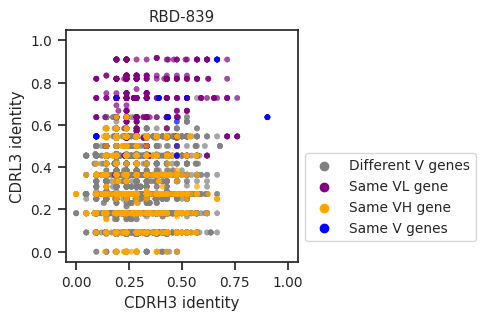

In [29]:
sns.set(rc = {'figure.figsize':(3,5),  'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = 0.9, palette='colorblind')
sns.set_style('ticks')

for hit in rbd_hit_df.index:
    if hit == 'RBD-839':  # Comment this line out to run for all, took ~21 seconds for all 9 binders
        plt.figure()
        training_seqs[hit + '_CDRH3_ID'] = training_seqs['CDR3.H'].apply(lambda x: lev_identity(rbd_hit_df['CDR3.H'].loc[hit], x))
        training_seqs[hit + '_CDRL3_ID'] = training_seqs['CDR3.L'].apply(lambda x: lev_identity(rbd_hit_df['CDR3.L'].loc[hit], x))

        training_seqs['V gene overlap ' + hit] = training_seqs.apply(lambda x: add_matching_gene_label(x, rbd_hit_df.loc[hit]), axis=1)
        palette = {'Same V genes':'blue', 'Same VH gene':'orange', 'Same VL gene':'purple', 'Different V genes': 'grey'}
        training_seqs['cat_order'] = training_seqs['V gene overlap ' + hit].map({'Same V genes':0, 'Same VH gene':1, 'Same VL gene':2, 'Different V genes': 3})

        ax = sns.scatterplot(data = training_seqs.sort_values(by='cat_order', ascending=False), x = hit + '_CDRH3_ID', y = hit + '_CDRL3_ID', hue = 'V gene overlap ' + hit, palette=palette, alpha=0.7, edgecolor=None, s = 15)

        plt.xlabel('CDRH3 identity')
        plt.ylabel('CDRL3 identity')
        plt.title(hit)

        plt.xlim(-0.05,1.05)
        plt.ylim(-0.05,1.05)

        ax.set_aspect('equal')

        plt.legend(bbox_to_anchor=(1,0.5))

### Calculating publicness of binders

In [31]:
same_VH ={}
same_genes = {}
cdrh3_hit = {}
for hit in rbd_hit_df.index:
    df = training_seqs[training_seqs[hit + '_CDRH3_ID']>=0.7]
    df = df.drop_duplicates(subset=['VH_abnum', 'VL_abnum'])
    cdrh3_hit[hit] = len(df)
    df = df[(df['V gene overlap ' + hit] == 'Same VH gene') | (df['V gene overlap ' + hit] == 'Same V genes')]

    same_VH[hit] = len(df)
    df = df[df[hit + '_CDRL3_ID'] >= 0.7]
    df = df[(df['V gene overlap ' + hit] == 'Same VL gene') | (df['V gene overlap ' + hit] == 'Same V genes')]

    same_genes[hit] = len(df)

pdf = pd.DataFrame([pd.Series(same_VH), pd.Series(same_genes), pd.Series(cdrh3_hit)]).T
pdf.columns = ['VH clone', 'VH + VL clone','CDRH3 > 70%']
pdf =pdf[['VH + VL clone','VH clone','CDRH3 > 70%']]
pdf = pdf.sort_values(by='VH clone', ascending=True)

clone_plot_df = pdf.copy()

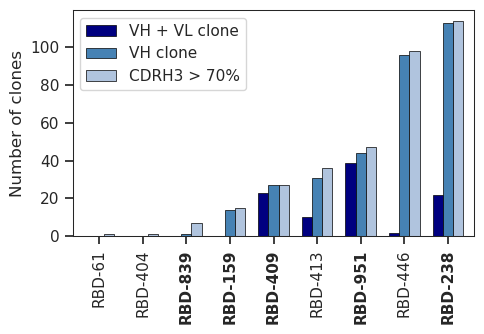

In [32]:
sns.set(rc = {'figure.figsize':(5,3.5),  'axes.edgecolor': 'white', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.linewidth':0.75}, font_scale = 1)
sns.set_style('ticks')

barplot = pdf.plot.bar(width=0.7, edgecolor='black', linewidth=0.5, legend=False, color=[ 'navy', 'steelblue', 'lightsteelblue']) #['silver', 'dimgrey', 'black']

plt.legend(bbox_to_anchor=(0.45,1),frameon=True)
plt.ylabel('Number of clones')
x_labels = barplot.get_xticklabels()
for label in x_labels:
    if label.get_text() in ['RBD-159', 'RBD-238', 'RBD-409', 'RBD-839', 'RBD-951',]:  # Bolding strong affinity binders identified by BLI
        label.set_fontweight('bold')
barplot.set_xticklabels(x_labels)

plt.tight_layout()

### Finding top matches in training data

In [33]:
def get_top_match(seq, chain):
    top_match_idx = training_seqs[chain + '_abnum'].apply(lambda y: distance(seq,y)).idxmin()
    match_distance = distance(training_seqs.loc[top_match_idx][chain + '_abnum'], seq)

    return top_match_idx

rbd_hit_df['top_VH_match'] = rbd_hit_df['VH'].apply(lambda x: get_top_match(x,'VH'))

In [28]:
rbd_hit_df = rbd_hit_df.rename(columns={'FR1.H':'FWR1.H', 'FR2.H':'FWR2.H', 'FR3.H':'FWR3.H', 'FR4.H':'FWR4.H', 'FR1.L':'FWR1.L', 'FR2.L': 'FWR2.L', 'FR3.L':'FWR3.L', 'FR4.L':'FWR4.L'})

Comparing regions based on lowest distance summed across VH and VL

In [36]:
def compare_regions(row, region, chain = 'VH'):
    match_row = row['top_VH_match']

    hit_region = row[region]
    train_region = training_seqs.loc[match_row][region]

    edit_dist = distance(hit_region, train_region)
    return edit_dist


for i in ['CDR1.H', 'CDR2.H', 'CDR3.H', 'FWR1.H', 'FWR2.H', 'FWR3.H', 'FWR4.H']:
    rbd_hit_df[i + '_dist'] = rbd_hit_df.apply(lambda x: compare_regions(x, i, 'VH'), axis=1)

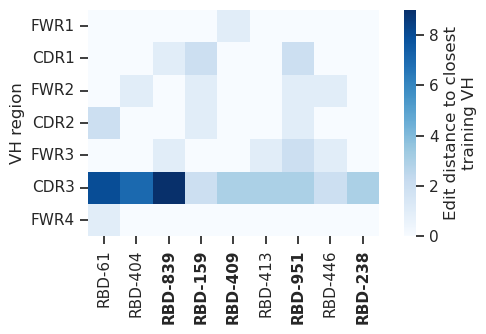

In [38]:
sns.set(rc = {'figure.figsize':(6,3.5),  'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True, 'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale = 1, palette='colorblind')
sns.set_style('ticks')


pdf = rbd_hit_df[['FWR1.H_dist', 'CDR1.H_dist', 'FWR2.H_dist', 'CDR2.H_dist', 'FWR3.H_dist', 'CDR3.H_dist', 'FWR4.H_dist']]
pdf.columns = ['FWR1', 'CDR1', 'FWR2', 'CDR2', 'FWR3', 'CDR3', 'FWR4']

pdf = pdf.loc[clone_plot_df.index].T

hm = sns.heatmap(pdf, xticklabels=True, yticklabels=True, square=True, cmap='Blues', cbar_kws={'label': 'Edit distance to closest\ntraining VH'})

x_labels = hm.get_xticklabels()
for label in x_labels:
    if label.get_text() in ['RBD-159', 'RBD-238', 'RBD-409', 'RBD-839', 'RBD-951',]:  # Bolding strong affinity binders
        label.set_fontweight('bold')
hm.set_xticklabels(x_labels)

plt.ylabel('VH region')

plt.tight_layout()